# How to Plot Horizontal and Vertical Slices of Swath Data with Python Using GPM_2ADPR

### Overview
This notebook contains some example code that shows how to use Python for plotting horizontal spatial maps and vertical cross sections (also known as curtain plots) of the Level 2 product [GPM_2ADPR](https://disc.gsfc.nasa.gov/datasets/GPM_2ADPR_07/summary?keywords=GPM_2ADPR_07). (GPM = Global Precipitation Measurement; DPR = Dual-Frequency Precipitation Radar).

### Prerequisites

This notebook was written using Python 3.10, and requires these libraries and files: 
- [NumPy v1.25.2](https://pypi.org/project/numpy/1.25.2/)
- [Matplotlib](http://matplotlib.org/)
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [h5py](https://www.h5py.org/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/quick-start/)
- Example Data: https://data.gesdisc.earthdata.nasa.gov/data/GPM_L2/GPM_2ADPR.07/2018/256/2A.GPM.DPR.V9-20211125.20180913-S141724-E154957.025808.V07A.HDF5
  - Please see [Data Access](https://disc.gsfc.nasa.gov/information/documents?title=Data%20Access) for help in downloading the data file.

The first step is to import the required Python libraries. They are used to read and plot the data. If any of the following import commands fail, check the local Python environment and install any missing packages.

In [1]:
import numpy as np
import earthaccess
import h5py                
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings("ignore")

First, we will search for the granule using the `earthaccess` library, querying by bounding box and shortname.

We recommend using the Earthdata Search tool to identify Level 1 and 2 granules of interest. Click the link [here](https://search.earthdata.nasa.gov/search/granules?p=C2179081499-GES_DISC&pg[0][v]=f&pg[0][id]=2A.GPM.DPR.V9-20211125.20180913-S141724-E154957.025808.V07A.HDF5&pg[0][gsk]=-start_date&q=GPM_2ADPR&sb[0]=120.42042%2C6.50071%2C134.11773%2C21.38736&tl=1572857242.724!5!!&lat=14.283925505419552&long=122.70754613178619&zoom=4) to view all search results, including alternative methods of downloading.

In [2]:
# This will work if Earthdata prerequisite files have already been generated
auth = earthaccess.login()

# To download multiple files, change the second temporal parameter
results = earthaccess.search_data(
    short_name="GPM_2ADPR",
    version="07",
    temporal=('2018-09-13', '2018-09-13'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(120.42042, 6.50071, 134.11773, 21.38736)
)

# Download granules to local path
downloaded_files = earthaccess.download(
    results[1],
    local_path='.', # Change this string to download to a different path
)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

The next step is to open the data file and load the required variables. In this example, we use the 3-dimensional variable _precipRate_ and the 2-dimensional _precipRateNearSurface_ from the Normal Scan swath group, along with the corresponding _Longitude_ and _Latitude_ variables.

In [3]:
# open the file, select the precipRate variables plus latitude and longitude
file = './2A.GPM.DPR.V9-20211125.20180913-S141724-E154957.025808.V07A.HDF5'
f = h5py.File(file,"r")
pr   = f['/FS/SLV/precipRate']
prns = f['/FS/SLV/precipRateNearSurface']
lon  = f["/FS/Longitude"]
lat  = f["/FS/Latitude"]
print('/FS/SLV/precipRate dimension sizes are:',pr.shape)

/FS/SLV/precipRate dimension sizes are: (7933, 49, 176)


Read the data values for both precipitation variables from the file and copy them into numpy N-dimensional arrays. Replace the FillValues with NaN.

In [4]:
# Read the data into numpy arrays and put NaN where FillValues are

# 3-Dimensional Precipitation Rate
prdata = np.ndarray(shape=pr.shape,dtype=float)
pr.read_direct(prdata)
np.place(prdata, prdata==pr.attrs.get('_FillValue'), np.nan)

# 2-Dimensional Near-Surface Precipitation Rage
prnsdata = np.ndarray(shape=prns.shape,dtype=float)
prns.read_direct(prnsdata)
np.place(prnsdata, prnsdata==prns.attrs.get('_FillValue'), np.nan)

The first example plot will show a segment of the 2-dimensional near-surface precipitation rate variable. The along-track dimension is cropped in order to zoom in on Typhoon Mangkhut as it neared the Philippine Islands on 13 September 2018. The following example code will generate the image in Figure 1.

In [5]:
# Subset the 2-Dimensional variable over the eye of Typhoon Mangkhut
# Choose the range of the subset, e.g.:
#   170 rows in the along-track dimension,
#   All 49 elements in the cross-track dimension,
start = 5500
end = 5670
mysub = prnsdata[start:end,:]
mylon = lon[start:end,:]
mylat = lat[start:end,:]

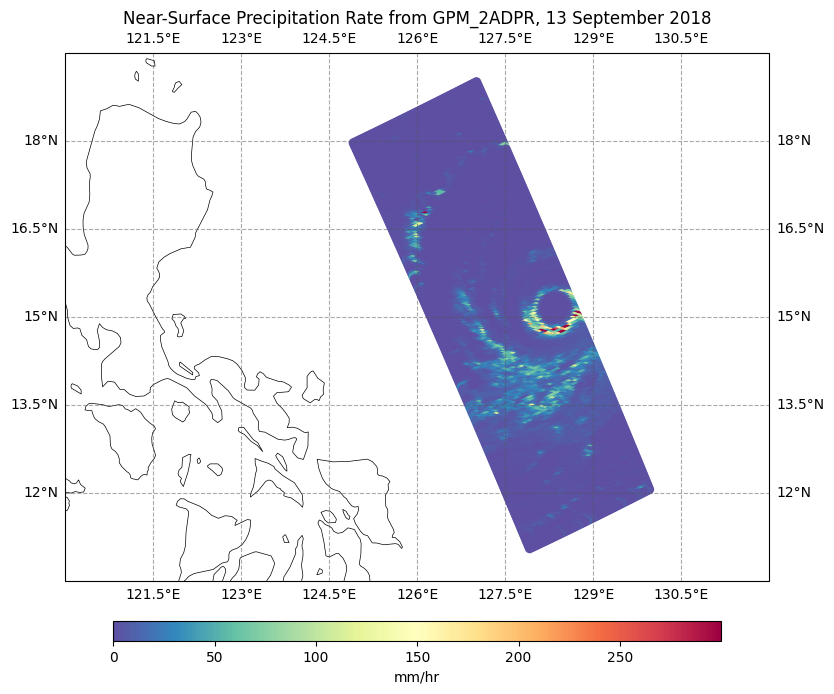

In [6]:
# Draw the subset of near-surface precipitation rate 
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([120,132,10.5,19.5])
plt.title('Near-Surface Precipitation Rate from GPM_2ADPR, 13 September 2018')

# Add coastlines and gridlines
ax.coastlines(resolution="50m",linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                  linewidth=0.8,color='#555555',alpha=0.5,linestyle='--')
# Axis labels
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True

# Plot the scatter diagram 
pp = plt.scatter(mylon, mylat, c=mysub, cmap=plt.cm.Spectral_r, transform=ccrs.PlateCarree())

# Add a colorbar to the bottom of the plot.
fig.subplots_adjust(bottom=0.15,left=0.06,right=0.94)
cbar_ax = fig.add_axes([0.12, 0.11, 0.76, 0.025])  
cbar = plt.colorbar(pp,cax=cbar_ax,orientation='horizontal')
cbar.set_label(label=prns.attrs.get('units').decode('utf-8'),size=10)


The second example plot will display a vertical cross-section of the 3-dimensional precipitation rate variable. The along-track dimension is cropped as in the previous plot, but only one element in the cross-track dimension is selected in order to plot the vertical slice through the center of the storm oriented in the along-track direction. Only the lowest 76 vertical levels (from 0 to 9500 meters) are plotted. The following example code will generate the image in Figure 2.

In [7]:
# ALONG-TRACK VERTICAL PROFILE
# Choose the range of the subset, e.g.:
#   170 rows in the along-track dimension,
#   One element in the cross-track dimension that slices through the eye of the storm
#   The lowest 76 elements in the vertical dimension
mysub2 = prdata[start:end,7,100:176]

# Transpose the array so the along-track dimension will be the X-Axis
#   and the vertical dimension will be the Y-Axis
subset2 = np.transpose(mysub2)

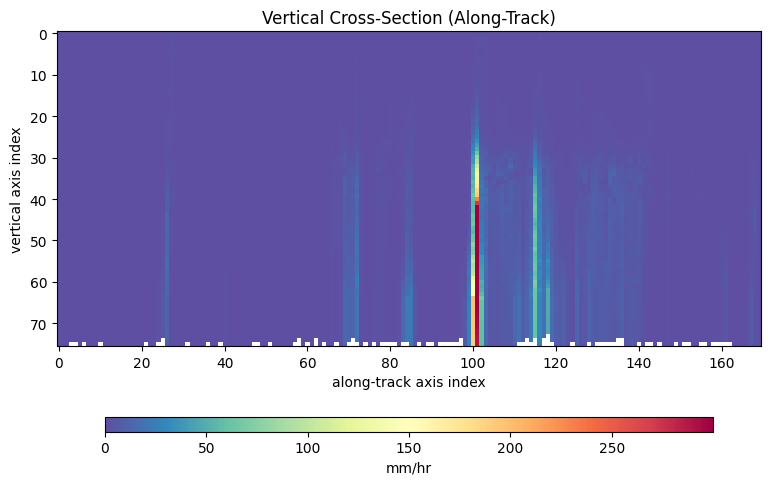

In [8]:
# Draw the ALONG-TRACK VERTICAL PROFILE
fig = plt.figure(figsize=(8,6))
ax = plt.axes()
ax.set_xlabel('along-track axis index')
ax.set_ylabel('vertical axis index')
ax.set_title('Vertical Cross-Section (Along-Track)')
pp = plt.imshow(subset2, cmap=plt.cm.Spectral_r)

# Add a colorbar to the bottom of the plot.
fig.subplots_adjust(bottom=0.15, left=0.06, right=0.94)
cbar_ax = fig.add_axes([0.12, 0.11, 0.76, 0.025])  
cbar = plt.colorbar(pp, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label=pr.attrs.get('units').decode('utf-8'),size=10)

The third example plot also shows a similar vertical cross-section of the 3-dimensional precipitation rate variable slicing through the center of the storm, but this one is oriented in the cross-track direction instead. As in the previous plot, only the lowest 76 vertical levels (from 0 to 9500 meters) are plotted. The following example code will generate the image in Figure 3.

In [9]:
# CROSS-TRACK VERTICAL PROFILE
# Choose the range of the subset, e.g.:
#   One complete row in the along-track dimension that slices through the eye of the storm
#   The lowest 76 elements in the vertical dimension
mysub3 = prdata[start+92,:,100:176]

# Transpose the array so the cross-track dimension will be the X-Axis
#   and the vertical dimension will be the Y-Axis
subset3 = np.transpose(mysub3)

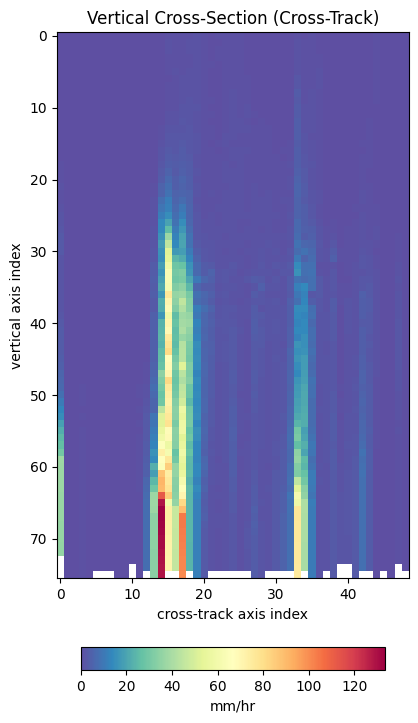

In [10]:
# Draw the CROSS-TRACK VERTICAL PROFILE
fig = plt.figure(figsize=(4, 9))
ax = plt.axes()
ax.set_xlabel('cross-track axis index')
ax.set_ylabel('vertical axis index')
ax.set_title('Vertical Cross-Section (Cross-Track)')
pp = plt.imshow(subset3, cmap=plt.cm.Spectral_r)

# Add a colorbar to the bottom of the plot.
fig.subplots_adjust(bottom=0.15,left=0.06, right=0.94)
cbar_ax = fig.add_axes([0.12, 0.11, 0.76, 0.025])  
cbar = plt.colorbar(pp, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label=pr.attrs.get('units').decode('utf-8'),size=10)